In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

dataset = pd.read_csv('dataset-14hr.csv')
plt.plot(dataset['timestamp'].head(1000), dataset['cpu'].head(1000))


In [ ]:
dataset.info()

In [ ]:
dataset.describe()

# Final Model Creation

In [ ]:
!nvidia-smi

Wed Nov 12 06:47:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install -q xgboost tensorflow scikit-learn joblib matplotlib seaborn

### Imports and Global Params

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import joblib
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

# Params
TIMESTEP_SECONDS = 5
PRED_HORIZON_SECONDS = 60
PRED_STEPS = PRED_HORIZON_SECONDS // TIMESTEP_SECONDS  # 12 if step=5s
SEQ_LEN = 60   # number of timesteps in sequence input (adjustable)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

!python --version

Python 3.12.12


### Import Data and Basic Checks

In [ ]:
DATA_PATH = "dataset-800min.csv"
df = pd.read_csv(DATA_PATH, parse_dates=["timestamp"])
df.sort_values("timestamp", inplace=True)
df.reset_index(drop=True, inplace=True)

print(df.shape)
display(df.head())
display(df.describe().T)

(9589, 5)


,timestamp,cpu,ram,disk,Y_cpu_+60s
0,2025-11-01 20:00:20,48.299060,7.73787,6106.541580,43.309091
1,2025-11-01 20:00:25,54.690085,7.73787,6106.874670,41.010163
2,2025-11-01 20:00:30,61.062928,7.73787,6628.193240,38.725045
3,2025-11-01 20:00:35,67.435772,7.73787,6628.193240,38.539716
4,2025-11-01 20:00:40,64.980545,7.73767,6702.667321,42.642326


,count,mean,min,25%,50%,75%,max,std
timestamp,9589,2025-11-02 02:39:50,2025-11-01 20:00:20,2025-11-01 23:20:05,2025-11-02 02:39:50,2025-11-02 05:59:35,2025-11-02 09:19:20,NaN
cpu,9589.0,50.374157,4.527273,34.696438,49.779992,65.227905,100.0,21.281098
ram,9589.0,13.818846,6.647001,7.508368,7.677036,7.973814,68.187553,14.4036
disk,9589.0,14393.373619,670.230173,5063.96131,6032.290909,8564.363636,3169525.582748,133363.797891
Y_cpu_+60s,9589.0,50.389698,4.527273,34.696438,49.810003,65.298107,100.0,21.289171


### Clean NaN and Inf...

In [ ]:
# Replace inf and drop rows with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)
n_before = len(df)
df.dropna(inplace=True)
n_after = len(df)
print(f"Dropped {n_before - n_after} rows containing NaN/inf")

Dropped 0 rows containing NaN/inf


### Add rolling-based anomaly flags (past-window only)

In [ ]:
# Use only past values by shifting statistics by 1
ROLL_WIN = 60

df["cpu_roll_median_past"] = df["cpu"].rolling(window=ROLL_WIN, min_periods=1).median().shift(1)
df["cpu_roll_std_past"] = df["cpu"].rolling(window=ROLL_WIN, min_periods=1).std().shift(1).fillna(1e-6)
df["cpu_zscore_past"] = (df["cpu"] - df["cpu_roll_median_past"]) / df["cpu_roll_std_past"]
df["is_anomaly_z"] = (df["cpu_zscore_past"].abs() > 3).astype(int)

# IsolationForest on raw features (fit on entire data but we will treat it as an engineering signal).
iso = IsolationForest(contamination=0.02, random_state=RANDOM_SEED)
iso_labels = iso.fit_predict(df[["cpu", "ram", "disk"]].fillna(method="ffill").values)
df["is_anomaly_iso"] = (iso_labels == -1).astype(int)

# anomaly severity
df["anomaly_severity"] = df["is_anomaly_z"] * np.abs(df["cpu_zscore_past"]) + df["is_anomaly_iso"] * 1.0

display(df[["timestamp", "cpu", "cpu_zscore_past", "is_anomaly_z", "is_anomaly_iso", "anomaly_severity"]].head(10))

/tmp/ipython-input-1196437736.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  iso_labels = iso.fit_predict(df[["cpu", "ram", "disk"]].fillna(method="ffill").values)


,timestamp,cpu,cpu_zscore_past,is_anomaly_z,is_anomaly_iso,anomaly_severity
0,2025-11-01 20:00:20,48.299060,NaN,0,0,NaN
1,2025-11-01 20:00:25,54.690085,6.391025e+06,1,0,6.391025e+06
2,2025-11-01 20:00:30,61.062928,2.117297e+00,0,0,0.000000e+00
3,2025-11-01 20:00:35,67.435772,1.997150e+00,0,0,0.000000e+00
4,2025-11-01 20:00:40,64.980545,8.627322e-01,0,0,0.000000e+00
5,2025-11-01 20:00:45,57.791677,-4.189791e-01,0,0,0.000000e+00
6,2025-11-01 20:00:50,51.963636,-1.064677e+00,0,0,0.000000e+00
7,2025-11-01 20:00:55,48.839154,-1.290660e+00,0,0,0.000000e+00
8,2025-11-01 20:01:00,48.129159,-1.127024e+00,0,0,0.000000e+00
9,2025-11-01 20:01:05,50.141803,-6.198487e-01,0,0,0.000000e+00


### Tabular feature engineering for XGBoost

In [ ]:
def build_tabular(df):
    d = df.copy()
    # time features
    d["hour"] = d["timestamp"].dt.hour
    d["minute"] = d["timestamp"].dt.minute
    d["dayofweek"] = d["timestamp"].dt.dayofweek
    d["hour_sin"] = np.sin(2*np.pi*d["hour"]/24)
    d["hour_cos"] = np.cos(2*np.pi*d["hour"]/24)

    # lags (in samples: 1->5s, 12->60s etc)
    lags = [1,2,3,6,12]
    for lag in lags:
        d[f"cpu_lag_{lag}"] = d["cpu"].shift(lag)
        d[f"ram_lag_{lag}"] = d["ram"].shift(lag)
        d[f"disk_lag_{lag}"] = d["disk"].shift(lag)

    # rolling windows (past only)
    windows = {"short":3, "med":12, "long":60}  # ~15s, 60s, 5min
    for name, w in windows.items():
        d[f"cpu_roll_mean_{name}"] = d["cpu"].rolling(window=w, min_periods=1).mean().shift(1)
        d[f"cpu_roll_std_{name}"] = d["cpu"].rolling(window=w, min_periods=1).std().shift(1).fillna(0)
        d[f"ram_roll_mean_{name}"] = d["ram"].rolling(window=w, min_periods=1).mean().shift(1)
        d[f"disk_roll_mean_{name}"] = d["disk"].rolling(window=w, min_periods=1).mean().shift(1)

    # ewm
    d["cpu_ewm_30"] = d["cpu"].ewm(span=30, adjust=False).mean().shift(1)

    # cross features
    d["cpu_x_ram"] = d["cpu"] * d["ram"]

    # keep target
    d["target"] = d["Y_cpu_+60s"]

    d = d.dropna().reset_index(drop=True)
    return d

tab_df = build_tabular(df)
print("Tabular features shape:", tab_df.shape)
display(tab_df.head())

Tabular features shape: (9577, 46)


,timestamp,cpu,ram,disk,Y_cpu_+60s,cpu_roll_median_past,cpu_roll_std_past,cpu_zscore_past,is_anomaly_z,is_anomaly_iso,...,cpu_roll_std_med,ram_roll_mean_med,disk_roll_mean_med,cpu_roll_mean_long,cpu_roll_std_long,ram_roll_mean_long,disk_roll_mean_long,cpu_ewm_30,cpu_x_ram,target
0,2025-11-01 20:01:20,43.309091,7.676337,5809.083967,37.145455,51.052720,7.310776,-1.059208,0,0,...,7.310776,7.635493,7385.090950,53.891889,7.310776,7.635493,7385.090950,50.856721,332.455157,37.145455
1,2025-11-01 20:01:25,41.010163,7.676137,8564.363636,36.265954,50.141803,7.590029,-1.203110,0,0,...,7.784383,7.630365,7360.302816,53.077828,7.590029,7.638635,7263.859644,50.369777,314.799623,36.265954
2,2025-11-01 20:01:30,38.725045,7.676087,9011.036163,35.287379,49.490478,7.973653,-1.350126,0,0,...,8.554065,7.625221,7565.093563,52.215852,7.973653,7.641314,7356.752786,49.765931,297.256803,35.287379
3,2025-11-01 20:01:35,38.539716,7.676087,8937.052256,34.381818,48.839154,8.436305,-1.220847,0,0,...,8.905628,7.620072,7763.663807,51.316464,8.436305,7.643632,7467.038345,49.053616,295.834205,34.381818
4,2025-11-01 20:01:40,42.642326,7.676087,8936.239841,33.485446,48.569107,8.753817,-0.677051,0,0,...,7.731806,7.614924,7956.068725,50.517918,8.753817,7.645660,7558.914214,48.375300,327.326195,33.485446


### Train/val/test split (time based) and scaling

In [ ]:
# time-based split
n = len(tab_df)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

train_df = tab_df.iloc[:train_end].copy()
val_df = tab_df.iloc[train_end:val_end].copy()
test_df = tab_df.iloc[val_end:].copy()

# feature columns
drop_cols = ["timestamp", "Y_cpu_+60s", "target"]
feature_cols = [c for c in tab_df.columns if c not in drop_cols]

# scaler fitted on train only
scaler = StandardScaler()
train_X = scaler.fit_transform(train_df[feature_cols])
val_X = scaler.transform(val_df[feature_cols])
test_X = scaler.transform(test_df[feature_cols])

train_y = train_df["target"].values
val_y = val_df["target"].values
test_y = test_df["target"].values

# save scaler
joblib.dump(scaler, "tab_scaler.joblib")
print("Train shape:", train_X.shape, "Val shape:", val_X.shape, "Test shape:", test_X.shape)

Train shape: (5746, 43) Val shape: (1915, 43) Test shape: (1916, 43)


### XGBoost training with anomaly-aware weights

In [ ]:
# compute sample weights (boost anomalies)
def sample_weights(df):
    w = np.ones(len(df))
    w += 0.5 * df["is_anomaly_z"].values
    w += 1.0 * df["is_anomaly_iso"].values
    return w

dtrain = xgb.DMatrix(train_X, label=train_y, weight=sample_weights(train_df))
dval = xgb.DMatrix(val_X, label=val_y, weight=sample_weights(val_df))

params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.05,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": RANDOM_SEED
}
watchlist = [(dtrain, "train"), (dval, "valid")]
xgb_model = xgb.train(params, dtrain, num_boost_round=1000, early_stopping_rounds=50, evals=watchlist, verbose_eval=50)
xgb_model.save_model("xgboost_model.json")
# val metrics
pred_val_xgb = xgb_model.predict(xgb.DMatrix(val_X))
print("XGB val RMSE:", np.sqrt(mean_squared_error(val_y, pred_val_xgb)))
print("XGB val MAE:", mean_absolute_error(val_y, pred_val_xgb))

[0]	train-rmse:20.57511	valid-rmse:21.77928
[50]	train-rmse:12.93337	valid-rmse:20.99067
[95]	train-rmse:10.11834	valid-rmse:21.13783
XGB val RMSE: 21.23972005552428
XGB val MAE: 17.372363030852597


### Build Sequence Dataset for LSTM

In [ ]:
# build sequences from df (original df, after anomaly columns and drops)
seq_cols = ["cpu", "ram", "disk", "is_anomaly_z", "anomaly_severity"]
# ensure df index aligns with tab_df dropping; re-generate a sequence-aligned df
seq_df = df.copy().reset_index(drop=True)

# drop any rows that aren't in tab_df (ensure sequence alignment by timestamp)
valid_timestamps = set(tab_df["timestamp"])
seq_df = seq_df[seq_df["timestamp"].isin(valid_timestamps)].reset_index(drop=True)

def make_sequences(df_seq, seq_cols, seq_len=SEQ_LEN, pred_steps=PRED_STEPS):
    Xs, ys, ts = [], [], []
    values = df_seq[seq_cols].values
    targets = df_seq["Y_cpu_+60s"].values
    for i in range(len(df_seq) - seq_len - pred_steps + 1):
        Xs.append(values[i:i+seq_len])
        # align: use the last timestep in sequence as the anchor, and target already is T+60
        ys.append(targets[i+seq_len-1])
        ts.append(df_seq["timestamp"].iloc[i+seq_len-1])
    return np.array(Xs), np.array(ys), ts

X_seq, y_seq, seq_ts = make_sequences(seq_df, seq_cols, seq_len=SEQ_LEN, pred_steps=PRED_STEPS)
print("Sequence data shape:", X_seq.shape, y_seq.shape)

# time split (same ratios)
n_seq = len(X_seq)
train_s = int(n_seq * 0.6)
val_s = int(n_seq * 0.8)

X_train_seq, y_train_seq = X_seq[:train_s], y_seq[:train_s]
X_val_seq, y_val_seq = X_seq[train_s:val_s], y_seq[train_s:val_s]
X_test_seq, y_test_seq = X_seq[val_s:], y_seq[val_s:]
print("Seq train/val/test shapes:", X_train_seq.shape, X_val_seq.shape, X_test_seq.shape)

Sequence data shape: (9506, 60, 5) (9506,)
Seq train/val/test shapes: (5703, 60, 5) (1901, 60, 5) (1902, 60, 5)


### Scale sequence channels and target

In [ ]:
# Scale each channel using scalers fit on training sequence
scalers_seq = []
for ch in range(X_train_seq.shape[2]):
    s = StandardScaler()
    # Flatten the sequence data for the current channel for fitting
    flat_train = X_train_seq[:,:,ch].reshape(-1, 1)
    s.fit(flat_train)

    # Transform the entire sequence data for the current channel
    X_train_seq[:,:,ch] = s.transform(X_train_seq[:,:,ch].reshape(-1, 1)).reshape(X_train_seq.shape[0], X_train_seq.shape[1])
    X_val_seq[:,:,ch]   = s.transform(X_val_seq[:,:,ch].reshape(-1, 1)).reshape(X_val_seq.shape[0], X_val_seq.shape[1])
    X_test_seq[:,:,ch]  = s.transform(X_test_seq[:,:,ch].reshape(-1, 1)).reshape(X_test_seq.shape[0], X_test_seq.shape[1])
    scalers_seq.append(s)

# scale targets for stable LSTM training
y_scaler = StandardScaler()
y_train_seq_s = y_scaler.fit_transform(y_train_seq.reshape(-1,1)).flatten()
y_val_seq_s = y_scaler.transform(y_val_seq.reshape(-1,1)).flatten()
joblib.dump(scalers_seq, "scalers_seq.joblib")
joblib.dump(y_scaler, "y_scaler.joblib")
print("Sequence scaling done.")

Sequence scaling done.


### Build LSTM model with LayerNormalization and gradient clipping

In [ ]:
def build_lstm_model(input_shape):
    inp = layers.Input(shape=input_shape)
    x = layers.LayerNormalization()(inp)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(1)(x)
    model = models.Model(inp, out)
    return model

lstm = build_lstm_model((SEQ_LEN, X_train_seq.shape[2]))
opt = optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)  # gentle lr + clipping
lstm.compile(optimizer=opt, loss="mse", metrics=["mae"])
lstm.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 60, 5)          │            10 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        35,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,011 (156.29 KB)

 Trainable params: 40,011 (156.29 KB)

 Non-trainable params: 0 (0.00 B)

### Train LSTM (with EarlyStopping)

In [ ]:
es = callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
history = lstm.fit(X_train_seq, y_train_seq_s,
                   validation_data=(X_val_seq, y_val_seq_s),
                   epochs=100,
                   batch_size=64,
                   callbacks=[es],
                   verbose=2)
# save model in Keras native format
lstm.save("lstm_model.keras")

Epoch 1/100
90/90 - 7s - 78ms/step - loss: 0.9580 - mae: 0.7994 - val_loss: 1.1085 - val_mae: 0.8534
Epoch 2/100
90/90 - 1s - 12ms/step - loss: 0.9374 - mae: 0.7902 - val_loss: 1.1078 - val_mae: 0.8525
Epoch 3/100
90/90 - 1s - 11ms/step - loss: 0.9219 - mae: 0.7827 - val_loss: 1.1073 - val_mae: 0.8519
Epoch 4/100
90/90 - 1s - 14ms/step - loss: 0.9171 - mae: 0.7802 - val_loss: 1.1024 - val_mae: 0.8498
Epoch 5/100
90/90 - 1s - 16ms/step - loss: 0.9063 - mae: 0.7750 - val_loss: 1.0969 - val_mae: 0.8479
Epoch 6/100
90/90 - 2s - 24ms/step - loss: 0.8992 - mae: 0.7710 - val_loss: 1.0945 - val_mae: 0.8468
Epoch 7/100
90/90 - 1s - 11ms/step - loss: 0.8912 - mae: 0.7670 - val_loss: 1.0904 - val_mae: 0.8453
Epoch 8/100
90/90 - 1s - 11ms/step - loss: 0.8927 - mae: 0.7668 - val_loss: 1.0888 - val_mae: 0.8451
Epoch 9/100
90/90 - 1s - 11ms/step - loss: 0.8838 - mae: 0.7636 - val_loss: 1.0861 - val_mae: 0.8438
Epoch 10/100
90/90 - 1s - 14ms/step - loss: 0.8800 - mae: 0.7622 - val_loss: 1.0845 - val_m

### LSTM predictions and inverse scaling

In [ ]:
pred_val_lstm_s = lstm.predict(X_val_seq).flatten()
pred_val_lstm = y_scaler.inverse_transform(pred_val_lstm_s.reshape(-1,1)).flatten()
print("LSTM val RMSE:", np.sqrt(mean_squared_error(y_val_seq, pred_val_lstm)))
print("LSTM val MAE:", mean_absolute_error(y_val_seq, pred_val_lstm))

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
LSTM val RMSE: 21.570426315069167
LSTM val MAE: 17.435215410618255


### Align XGBoost and LSTM predictions for ensemble

In [ ]:
# align predictions to the same timestamps.
# produce tabular XGBoost predictions for the sequence anchor timestamps used by LSTM val set.

# Build a helper: for each sequence window end timestamp, get tabular features row from tab_df with same timestamp
val_seq_timestamps = seq_ts[train_s:val_s]  # timestamps for LSTM val endpoints

# create a map from timestamp->row index in tab_df
tab_index = {ts: i for i, ts in enumerate(tab_df["timestamp"])}

# gather tabular feature rows for those timestamps
indices = [tab_index.get(pd.Timestamp(t)) for t in val_seq_timestamps]
# drop any None (for safety)
valid_pairs = [(i, idx) for i, idx in enumerate(indices) if idx is not None]
seq_idx_list, tab_idx_list = zip(*valid_pairs)

# XGBoost predictions for corresponding tabular rows
X_tab_for_lstm_val = tab_df.iloc[list(tab_idx_list)][feature_cols]
X_tab_for_lstm_val_scaled = scaler.transform(X_tab_for_lstm_val)
pred_val_xgb_for_lstm = xgb_model.predict(xgb.DMatrix(X_tab_for_lstm_val_scaled))

# Align lengths and compare
L = min(len(pred_val_xgb_for_lstm), len(pred_val_lstm))
pred_xgb_al = pred_val_xgb_for_lstm[:L]
pred_lstm_al = pred_val_lstm[:L]
y_true_al = y_val_seq[:L]

print("Aligned lengths:", L)
print("XGB aligned RMSE:", np.sqrt(mean_squared_error(y_true_al, pred_xgb_al)))
print("LSTM aligned RMSE:", np.sqrt(mean_squared_error(y_true_al, pred_lstm_al)))


Aligned lengths: 1901
XGB aligned RMSE: 21.19776085806889
LSTM aligned RMSE: 21.570426315069167


### Simple weighted ensemble and evaluation

Weights (xgb, lstm): 0.5043568067932989 0.08418081426332706
Ensemble val RMSE: 30.682436705097302
Ensemble val MAE: 25.279236757537525
Ensemble val R2: -0.9741316006819889


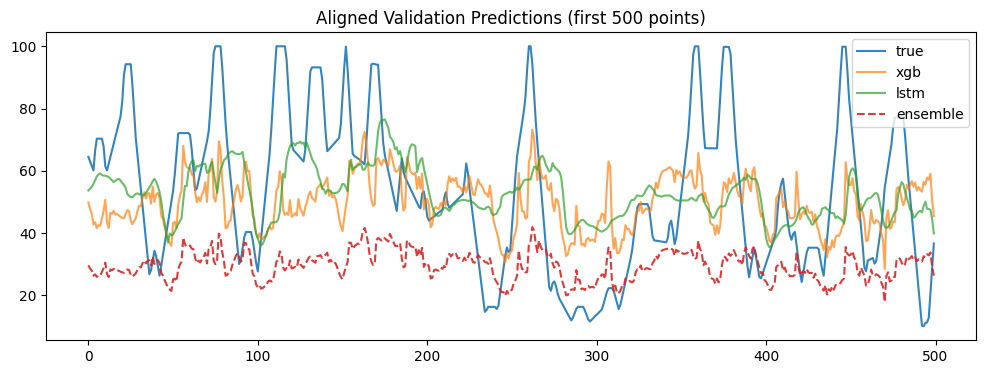

In [ ]:
# weights inversely proportional to RMSE on aligned validation
rmse_x = np.sqrt(mean_squared_error(y_true_al, pred_xgb_al))
rmse_l = np.sqrt(mean_squared_error(y_true_al, pred_lstm_al))
w_x = 1.0 / (rmse_x + 1e-8)
w_l = 1.0 / (rmse_l + 1e-8)
w_x /= (w_x + w_l); w_l /= (w_x + w_l)  # normalize (a bit redundant but ok)
print("Weights (xgb, lstm):", w_x, w_l)

ensemble_val = w_x * pred_xgb_al + w_l * pred_lstm_al
print("Ensemble val RMSE:", np.sqrt(mean_squared_error(y_true_al, ensemble_val)))
print("Ensemble val MAE:", mean_absolute_error(y_true_al, ensemble_val))
print("Ensemble val R2:", r2_score(y_true_al, ensemble_val))

# plot example
plt.figure(figsize=(12,4))
plt.plot(y_true_al[:500], label="true", alpha=0.9)
plt.plot(pred_xgb_al[:500], label="xgb", alpha=0.7)
plt.plot(pred_lstm_al[:500], label="lstm", alpha=0.7)
plt.plot(ensemble_val[:500], label="ensemble", alpha=0.9, linestyle="--")
plt.legend(); plt.title("Aligned Validation Predictions (first 500 points)")
plt.show()

### Final test evaluation (align same way)

In [ ]:
# Align on test set timestamps similarly: get sequence test timestamps, pick corresponding tab rows
test_seq_timestamps = seq_ts[val_s:]  # sequence endpoints for test
indices_test = [tab_index.get(pd.Timestamp(t)) for t in test_seq_timestamps]
valid_pairs_test = [(i, idx) for i, idx in enumerate(indices_test) if idx is not None]
seq_idx_list_t, tab_idx_list_t = zip(*valid_pairs_test)

X_tab_for_lstm_test = tab_df.iloc[list(tab_idx_list_t)][feature_cols]
X_tab_for_lstm_test_scaled = scaler.transform(X_tab_for_lstm_test)
pred_test_xgb = xgb_model.predict(xgb.DMatrix(X_tab_for_lstm_test_scaled))

# LSTM predictions on test (already computed X_test_seq)
pred_test_lstm_s = lstm.predict(X_test_seq[:len(pred_test_xgb)])  # ensure same length
pred_test_lstm = y_scaler.inverse_transform(pred_test_lstm_s).flatten()

L_test = min(len(pred_test_xgb), len(pred_test_lstm))
ensemble_test = w_x * pred_test_xgb[:L_test] + w_l * pred_test_lstm[:L_test]
y_test_al = y_test_seq[:L_test]

print("Test RMSE XGB:", np.sqrt(mean_squared_error(y_test_al, pred_test_xgb[:L_test])))
print("Test RMSE LSTM:", np.sqrt(mean_squared_error(y_test_al, pred_test_lstm)))
print("Test RMSE Ensemble:", np.sqrt(mean_squared_error(y_test_al, ensemble_test)))

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Test RMSE XGB: 22.26548322117961
Test RMSE LSTM: 22.139465039207828
Test RMSE Ensemble: 29.122792600523177


### Save artifacts

In [ ]:
# save models/scalers
xgb_model.save_model("xgboost_model_final.json")
lstm.save("lstm_model.final.keras")
joblib.dump(scaler, "tab_scaler_final.joblib")
joblib.dump(y_scaler, "y_scaler_final.joblib")

print("Saved models and scalers.")

Saved models and scalers.


In [ ]:
import numpy as np
err_x = y_true_al - pred_xgb_al
err_l = y_true_al - pred_lstm_al
print("err corr:", np.corrcoef(err_x, err_l)[0,1])

err corr: 0.9248272621149886


In [ ]:
!python --version

Python 3.12.12
